<a href="https://colab.research.google.com/github/sreent/large-language-model/blob/main/2%20Embeddings%20and%20Vector%20Search%20-%20Lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Embeddings and Vector Search

Converting text into embedding vectors is the first step to any text processing pipeline. As the amount of text gets larger, there is often a need to save these embedding vectors into a dedicated vector index or library, so that developers won't have to recompute the embeddings and the retrieval process is faster. We can then search for documents based on our intended query and pass these relevant documents into a language model (LM) as additional context. We also refer to this context as supplying the LM with "state" or "memory". The LM then generates a response based on the additional context it receives!

In this notebook, we will implement the full workflow of text vectorization, vector search, and question answering workflow. While we use [FAISS](https://faiss.ai/) (vector library) and [ChromaDB](https://docs.trychroma.com/) (vector database), and a Hugging Face model, know that you can easily swap these tools out for your preferred tools or models!

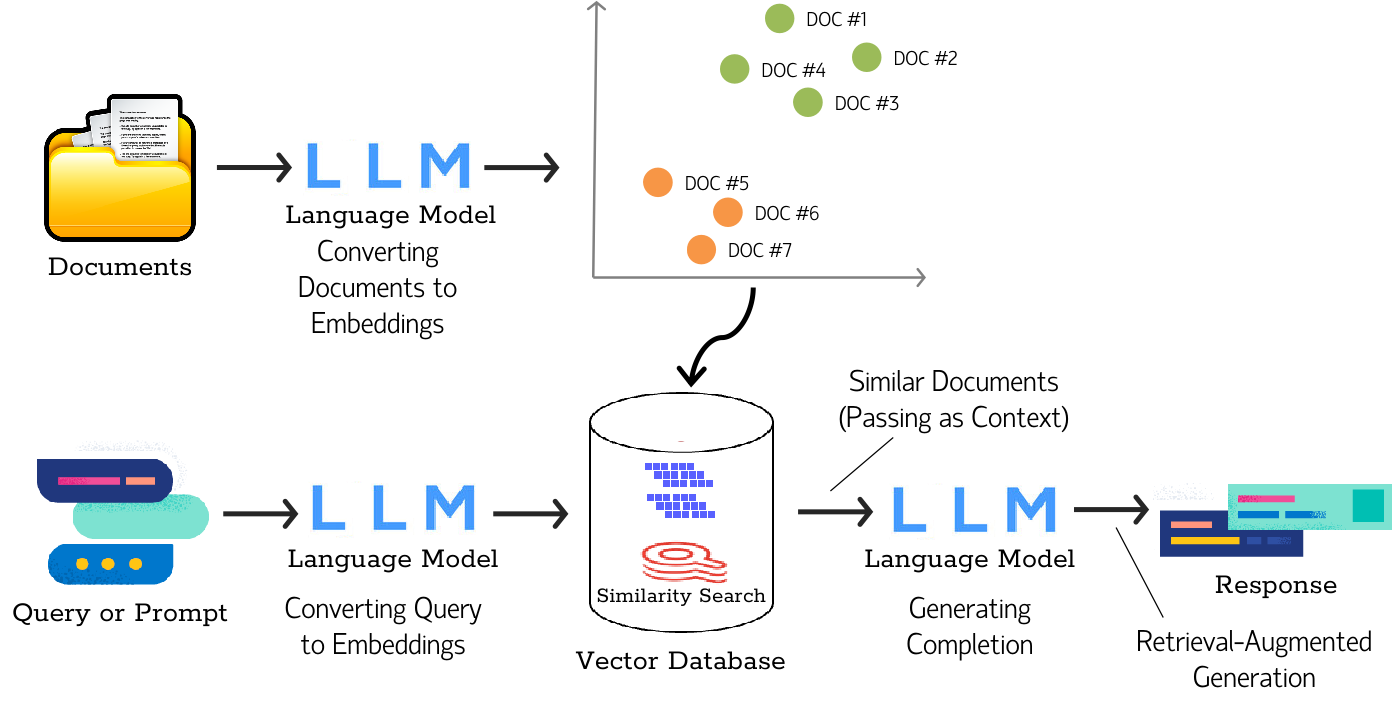

##Learning Objectives
1. Implement the workflow of reading text, converting text to embeddings, saving them to FAISS and ChromaDB
2. Query for similar documents using FAISS and ChromaDB
3. Apply a Hugging Face language model for question answering!

### Libraries:
* [transformers](https://github.com/huggingface/transformers) is for Hugging Face's transformer models
* [datasets](https://github.com/huggingface/datasets) is for Hugging Face's datasets
* [faiss](https://github.com/facebookresearch/faiss) is for FAISS library
* [chromadb](https://github.com/chroma-core/chroma) is for ChromaDB vector database

In [ ]:
!pip -q install git+https://github.com/huggingface/transformers
!pip -q install git+https://github.com/huggingface/datasets
!pip -q install faiss-cpu==1.7.4 chromadb==0.3.21

## Step 1: Reading dataCommon LLM applications

In this section, we are going to use the data on <a href="https://newscatcherapi.com/" target="_blank">news topics collected by the NewsCatcher team</a>, who collect and index news articles and release them to the open-source community. The dataset can be downloaded from <a href="https://www.kaggle.com/kotartemiy/topic-labeled-news-dataset" target="_blank">Kaggle</a>.


In [ ]:
import pandas as pd

# URL for our news dataset, labelled_newscatcher_dataset.csv
URL = "https://drive.google.com/file/d/1TWP6hD1vynwvd3UVSmJrLh4Sf-Ew6YQ9/view?usp=sharing"
FILE_PATH = "https://drive.google.com/uc?export=download&id=" + URL.split("/")[-2]

pdf = pd.read_csv(FILE_PATH, sep=";")
pdf["id"] = pdf.index
display(pdf)

## Vector Library: FAISS
Vector libraries are often sufficient for small, static data. Since it's not a full-fledged database solution, it doesn't have the CRUD (Create, Read, Update, Delete) support. Once the index has been built, if there are more vectors that need to be added/removed/edited, the index has to be rebuilt from scratch.

That said, vector libraries are easy, lightweight, and fast to use. Examples of vector libraries are [FAISS](https://faiss.ai/), [ScaNN](https://github.com/google-research/google-research/tree/master/scann), [ANNOY](https://github.com/spotify/annoy), and [HNSM](https://arxiv.org/abs/1603.09320).

FAISS has several ways for similarity search: L2 (Euclidean distance), cosine similarity. You can read more about their implementation on their [GitHub](https://github.com/facebookresearch/faiss/wiki/Getting-started#searching) page or [blog post](https://engineering.fb.com/2017/03/29/data-infrastructure/faiss-a-library-for-efficient-similarity-search/). They also published their own [best practice guide here](https://github.com/facebookresearch/faiss/wiki/Guidelines-to-choose-an-index).

If you'd like to read up more on the comparisons between vector libraries and databases, [here is a good blog post](https://weaviate.io/blog/vector-library-vs-vector-database#feature-comparison---library-versus-database).


The overall workflow of FAISS is captured in the diagram below.
<img src="https://miro.medium.com/v2/resize:fit:1400/0*ouf0eyQskPeGWIGm" width=700>

Source: [How to use FAISS to build your first similarity search by Asna Shafiq](https://medium.com/loopio-tech/how-to-use-faiss-to-build-your-first-similarity-search-bf0f708aa772).



In [ ]:
from sentence_transformers import InputExample

pdf_subset = pdf.head(1000)

def example_create_fn(doc1: pd.Series) -> InputExample:
    """
    Helper function that outputs a sentence_transformer guid, label, and text
    """
    return InputExample(texts=[doc1])

faiss_train_examples = pdf_subset.apply(
    lambda x: example_create_fn(x["title"]), axis=1
).tolist()

## Step 2: Vectorize text into embedding vectors
We will be using `Sentence-Transformers` [library](https://www.sbert.net/) to load a language model to vectorize our text into embeddings. The library hosts some of the most popular transformers on [Hugging Face Model Hub](https://huggingface.co/sentence-transformers).
Here, we are using the `model = SentenceTransformer("all-MiniLM-L6-v2")` to generate embeddings.


In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer(
    "all-MiniLM-L6-v2",
)  # Use a pre-cached model
faiss_title_embedding = model.encode(pdf_subset.title.values.tolist())
len(faiss_title_embedding), len(faiss_title_embedding[0])

## Step 3: Saving embedding vectors to FAISS index
Below, we create the FAISS index object based on our embedding vectors, normalize vectors, and add these vectors to the FAISS index.


In [ ]:
import numpy as np
import faiss

pdf_to_index = pdf_subset.set_index(["id"], drop=False)
id_index = np.array(pdf_to_index.id.values).flatten().astype("int")

content_encoded_normalized = faiss_title_embedding.copy()
faiss.normalize_L2(content_encoded_normalized)

# Index1DMap translates search results to IDs: https://faiss.ai/cpp_api/file/IndexIDMap_8h.html#_CPPv4I0EN5faiss18IndexIDMapTemplateE
# The IndexFlatIP below builds index
index_content = faiss.IndexIDMap(faiss.IndexFlatIP(len(faiss_title_embedding[0])))
index_content.add_with_ids(content_encoded_normalized, id_index)

## Step 4: Search for relevant documents

We define a search function below to first vectorize our query text, and then search for the vectors with the closest distance.


In [ ]:
def search_content(query, pdf_to_index, k=3):
    query_vector = model.encode([query])
    faiss.normalize_L2(query_vector)

    # We set k to limit the number of vectors we want to return
    top_k = index_content.search(query_vector, k)
    ids = top_k[1][0].tolist()
    similarities = top_k[0][0].tolist()
    results = pdf_to_index.loc[ids]
    results["similarities"] = similarities
    return results

Now you can query for similar content! Notice that you did not have to configure any database networks beforehand nor pass in any credentials. FAISS works locally with your code.


In [ ]:
display(search_content("animal", pdf_to_index))

Up until now, we haven't done the last step of conducting Q/A with a language model yet. We are going to demonstrate this with Chroma, a vector database.


## Vector Database: Chroma

Chroma is an open-source embedding database. The company just raised its [seed funding in April 2023](https://www.trychroma.com/blog/seed) and is quickly becoming popular to support LLM-based applications.


In [ ]:
# create a folder required by ChromaDB for persisting its data
!mkdir -p /content/user_db

In [ ]:
import chromadb
from chromadb.config import Settings

chroma_client = chromadb.Client(
    Settings(
        chroma_db_impl="duckdb+parquet",
        persist_directory="/content/user_db",  # this is an optional argument. If you don't supply this, the data will be ephemeral
    )
)


### Chroma Concept: Collection

Chroma `collection` is akin to an index that stores one set of your documents.

According to the [docs](https://docs.trychroma.com/getting-started):
> Collections are where you will store your embeddings, documents, and additional metadata

The nice thing about ChromaDB is that if you don't supply a model to vectorize text into embeddings, it will automatically load a default embedding function, i.e. `SentenceTransformerEmbeddingFunction`. It can handle tokenization, embedding, and indexing automatically for you. If you would like to change the embedding model, read [here on how to do that](https://docs.trychroma.com/embeddings). TLDR: you can add an optional `model_name` argument.

You can read [the documentation here](https://docs.trychroma.com/usage-guide#using-collections) on rules for collection names.


In [ ]:
collection_name = "my_news"

# If you have created the collection before, you need to delete the collection first
if len(chroma_client.list_collections()) > 0 and collection_name in [chroma_client.list_collections()[0].name]:
    chroma_client.delete_collection(name=collection_name)

print(f"Creating collection: '{collection_name}'")
collection = chroma_client.create_collection(name=collection_name)

### Step 1: Add data to collection

Since we are re-using the same data, we can skip the step of reading data. As mentioned in the text above, Chroma can take care of text vectorization for us, so we can directly add text to the collection and Chroma will convert the text into embeddings behind the scene.


In [ ]:
display(pdf_subset)

Each document must have a unique `id` associated with it and it is up to you to check that there are no duplicate ids.

Adding data to collection will take some time to run, especially when there is a lot of data. In the cell below, we intentionally write only a subset of data to the collection to speed things up.


In [ ]:
collection.add(
    documents=pdf_subset["title"][:100].tolist(),
    metadatas=[{"topic": topic} for topic in pdf_subset["topic"][:100].tolist()],
    ids=[f"id{x}" for x in range(100)],
)

### Step 2: Query for 10 relevant documents on "space"

We will return 10 most relevant documents. You can think of `10` as 10 nearest neighbors. You can also change the number of results returned as well.


In [ ]:
import json

results = collection.query(query_texts=["space"], n_results=10)

print(json.dumps(results, indent=4))

### Bonus: Add filter statement

In addition to conducting relevancy search, we can also add filter statements. Refer to the [documentation](https://docs.trychroma.com/usage-guide#using-where-filters) for more information.


In [ ]:
collection.query(query_texts=["space"], where={"topic": "SCIENCE"}, n_results=10)

### Bonus: Update data in a collection

Unlike a vector library, vector databases support changes to the data so we can update or delete data.

Indeed, we can update or delete data in a Chroma collection.


In [ ]:
collection.delete(ids=["id0"])

The record with `ids=0` is no longer present.

In [ ]:
collection.get(
    ids=["id0"],
)

We can also update a specific data point.

In [ ]:
collection.get(
    ids=["id2"],
)

In [ ]:
collection.update(
    ids=["id2"],
    metadatas=[{"topic": "TECHNOLOGY"}],
)

## Prompt engineering for question answering

Now that we have identified documents about space from the news dataset, we can pass these documents as additional context for a language model to generate a response based on them!

We first need to pick a `text-generation` model. Below, we use a Hugging Face model. You can also use OpenAI as well, but you will need to get an Open AI token and [pay based on the number of tokens](https://openai.com/pricing).

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

model_id = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_id)
lm_model = AutoModelForCausalLM.from_pretrained(model_id)

pipe = pipeline(
    "text-generation",
    model=lm_model,
    tokenizer=tokenizer,
    max_new_tokens=512,
    device_map="auto",
)

Here's where prompt engineering, which is developing prompts, comes in. We pass in the context in our `prompt_template` but there are numerous ways to write a prompt. Some prompts may generate better results than the others and it requires some experimentation to figure out how best to talk to the model. Each language model behaves differently to prompts.

Our prompt template below is inspired from a [2023 paper on program-aided language model](https://arxiv.org/pdf/2211.10435.pdf). The authors have provided their sample prompt template [here](https://github.com/reasoning-machines/pal/blob/main/pal/prompt/date_understanding_prompt.py).

The following links also provide some helpful guidance on prompt engineering:
- [Prompt engineering with OpenAI](https://help.openai.com/en/articles/6654000-best-practices-for-prompt-engineering-with-openai-api)
- [GitHub repo that compiles best practices to interact with ChatGPT](https://github.com/f/awesome-chatgpt-prompts)


In [ ]:
question = "What's the latest news on space development?"
context = " ".join([f"#{str(i)}" for i in results["documents"][0]])
prompt_template = f"Relevant context: {context}\n\n The user's question: {question}"

In [ ]:
lm_response = pipe(prompt_template)
print(lm_response[0]["generated_text"])

You have just completed the implementation of your first text vectorization, search, and question answering workflow (that requires prompt engineering)!

In the lab, you will apply your newly gained knowledge to a different dataset. You can also check out the optional modules on Pinecone and Weaviate to learn how to set up vector databases that offer enterprise offerings.
